In [1]:
# If running on Google Colab, only cleverhans needs installation. This can be done via:
!pip install cleverhans

# If running locally, we've listed (TODO) our dependencies in requirements.txt, so the following
# should get everything up and running:
# !pip install -r requirements.txt

import numpy
import keras
import pandas
import requests
import io
import zipfile
import os
import re
import cleverhans
import tensorflow
import seaborn

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.attacks import SaliencyMapMethod
from cleverhans.attacks_tf import jacobian_augmentation
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval

from keras.models import Sequential
from keras.layers import Dense

numpy.random.seed(0xC0FFEE)
tensorflow.set_random_seed(0xC0FFEE)
rng = numpy.random.RandomState(0xC0FFEE)

    100% |████████████████████████████████| 204kB 26.1MB/s 
    100% |████████████████████████████████| 51kB 19.1MB/s 


Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Dataset

## Loading data

Run the below code to download a copy of the dataset (if you don't already have it):

In [0]:
response = requests.get("http://www.schonlau.net/masquerade/masquerade-data.zip")

dataset_file = io.BytesIO(response.content)

zipped_dataset = zipfile.ZipFile(dataset_file)
zipped_dataset.extractall('data/masquerade-data')

In [0]:
# http://www.schonlau.net/intrusion.html
# download Masquerade Data (zip File)

import pandas as pd
directory = './data/masquerade-data'

In [0]:
def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [0]:
users = range(1,51)
df = pd.DataFrame()

for filename in sorted_nicely(os.listdir(directory)):
    user = pd.read_csv(os.path.join(directory, filename), header=None)
    df = pd.concat([df, user], axis = 1)
    
df.columns = sorted_nicely(os.listdir(directory))

We've loaded in the dataset, but need to do a little co-ercion to get it how we need. Firstly, make sure that all the values in this dataframe are categorical variables which share the same data type:

In [0]:
commands = numpy.unique(df)
command_dtype = pandas.api.types.CategoricalDtype(commands)

for column in df:
    df[column] = df[column].astype(command_dtype)

In [0]:
labelled, unlabelled = df.head(5000), df.tail(len(df) - 5000)  # ignore unlabeled

Plan is convert to the following format:

  user, command1?, command2?, ..., 
  
 so the first column is a label, and the second a one-hot encoding of the command.
 
 When we do the rolling window aggregation, we just sum the columns (per-user).
 
 Use [rolling window sampling](https://pcp.io/books/PCP_PG/html/LE42586-PARENT.html).

In [8]:
def rolling_window_command_counts(commands, window_size):
    
    # Save a copy the name of the series to add again to our output. This will preserve the mapping of
    # user identifier to (it's column header in the dataframe it came from), which in
    # this case is the user identifier. 
    user = commands.name

    # Convert the single column "which command was run?" to a column for each
    # command, which says "was command <x> run?"
    commands = pandas.get_dummies(commands)

    # Take a rolling sample of the last 100 commands, then sum each "was command <x> run?"
    # columns to give a bunch "command <x> was run <y> times in this window".
    command_counts = commands.rolling(window=window_size).aggregate(numpy.sum)

    # Remove the first 100 rows because they contain data from blocks of size < 100.
    command_counts = command_counts[window_size-1:]
    
    # Preserve the user identifier (see top of function) as a new column:
    
    # First, a nasty hack: https://github.com/pandas-dev/pandas/issues/19136
    command_counts = command_counts.rename(columns=str)  
    
    # Then, add in the user (with an adhoc parser to turn the label into a number)
    command_counts['user'] = int(user.replace('User', ''))

    return command_counts

# Example
rolling_window_command_counts(labelled['User1'], 100)

,%backup%,.java_wr,.maker_w,.wrapper,.xinitrc,.xsessio,1.1,1.2,1.3,4Dwm,...,xxx,yacc,ypcat,yppasswd,z,zip,zsh,zubs,zz2,user
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [9]:
labelled_dataset = pandas.concat([
        rolling_window_command_counts(commands, 100)
        for user, commands in labelled.iteritems()
    ],
    ignore_index=True,  # reset index to go from 0 to 4900
)

labelled_dataset

,%backup%,.java_wr,.maker_w,.wrapper,.xinitrc,.xsessio,1.1,1.2,1.3,4Dwm,...,xxx,yacc,ypcat,yppasswd,z,zip,zsh,zubs,zz2,user
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [0]:
labels = labelled_dataset['user'] - 1
dataset = labelled_dataset.drop(columns=['user'])

In [0]:
labels =  keras.utils.to_categorical(labels, num_classes=50)

In [0]:
from sklearn.model_selection import train_test_split

training_data, testing_data, training_labels, testing_labels = train_test_split(
    dataset,
    labels, 
    test_size=0.10,
)

# Building the Oracle

In [0]:
oracle = Sequential()

In [0]:
input_layer = Dense(
    units=856,
    activation='relu',
    input_dim=856,
)

In [0]:
hidden_layer = Dense(
    units=30,
    activation='relu',
)

In [0]:
output_layer = Dense(
    units=50,
    activation='softmax',
)

In [17]:
oracle.add(input_layer)
oracle.add(hidden_layer)
oracle.add(output_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
oracle.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# Training Oracle on Dataset

In [19]:
oracle.fit(training_data,  training_labels, epochs=3, batch_size=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
220545/220545 [==============================] - 82s 370us/step - loss: 0.1868 - acc: 0.9465
Epoch 2/3
220545/220545 [==============================] - 81s 367us/step - loss: 0.0652 - acc: 0.9780
Epoch 3/3
220545/220545 [==============================] - 83s 374us/step - loss: 0.0520 - acc: 0.9821


In [20]:
oracle

# Evaluating the Oracle

In [21]:
loss, accuracy = oracle.evaluate(testing_data, testing_labels)

24505/24505 [==============================] - 2s 76us/step


In [22]:
loss, accuracy

(0.039122308926002006, 0.9845337686356757)

In [23]:
oracle.metrics_names

['loss', 'acc']

# Building a Substitute Model

Attack Model:
  - We only have access to the oracle as a black box, allowing the following interactions:
    - Send input.
    - Receive a prediction.

Need to search the input space to find the decision boundaries, use these inputs to train the substitute model. Note: we can overfit here and it's absolutely fine!

The original "Blackbox... " paper has an accompanying Python library,  [cleverhans](https://github.com/tensorflow/cleverhans/), which we use to implement this attack.

First, mirror the architecture of the oracle:
    

In [0]:
substitute = Sequential()

input_layer = Dense(
    units=856,
    activation='relu',
    input_dim=856,
)
hidden_layer = Dense(
    units=30,
    activation='relu',
)
output_layer = Dense(
    units=50,
    activation='softmax',
)

substitute.add(input_layer)
substitute.add(hidden_layer)
substitute.add(output_layer)

# We need to convert our substitute model into the cleverhans format.
substitute_ch = KerasModelWrapper(substitute)

In [0]:
tensorflow_session = tensorflow.Session()

We start by giving the adversary a small dataset with which to bootstrap it's search. Initially, we give it a random sample of 5% of the original data set. 

We can then steal the rest of the dataset to determine the accuracy of our substitute model. **NOTE** They do this in the tutorial code but, is it legit? Or are we cheating?


In [26]:
adversary_training_set, adversary_test_set = train_test_split(
    labelled_dataset,
    train_size=0.05,
    stratify=labelled_dataset['user'],
)

adversary_training_inputs = adversary_training_set.drop('user', axis='columns')
adversary_training_labels = adversary_training_set['user'] - 1  # keras requires 0 based index

# For some reason cleverhans doesn't detect a GPU when it runs, but our models at the top using
# keras _do_. I think this creates a type mis-match: code running on the GPU uses numpy.float64
# whilst the cleverhans stuff runs on the CPU and extects numpy.float32 (or vica versa).
#   -> This is why this dodgy type conversion exists:
adversary_training_inputs = adversary_training_inputs.values.astype(numpy.float32)
adversary_training_labels = adversary_training_labels.values

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Define input placeholders for the tensor flow model (these are then used to generate new points)

In [0]:
number_of_users = 50
number_of_commands = 856

input_placeholder = tensorflow.placeholder(
    tensorflow.float32,
    shape=(None, number_of_commands)
)

output_placeholder = tensorflow.placeholder(
    tensorflow.float32,
    shape=(None, number_of_users)
)

Get the oracles predictions for the "bootstrap" inputs:

In [0]:
bootstrap_oracle_predictions = oracle.predict(adversary_training_inputs)

Train substitute using method from https://arxiv.org/abs/1602.02697

In [0]:
# Define the predictions and loss of the model, symbolically in TensorFlow (i.e. these variables 
# point to the result of calculations that haven't been performed yet)

substitute_predictions = substitute_ch.get_logits(input_placeholder)
substitute_loss = CrossEntropy(substitute_ch, smoothing=0)

Here we define a Jacobian Graph/Model (**TODO** What in the world is this? and why are we using it?).

In [30]:
# Define the Jacobian symbolically using TensorFlow
grads = jacobian_graph(substitute_predictions, input_placeholder, number_of_users)

number_of_dataset_augmentation_batches = 5
dataset_augmentation_batch_size = 512


stepsize = 1  # this is the step-size of the Jacobian augmentation (we are working in ints so use 1).


# Train the substitute and augment dataset alternatively
for batch in range(number_of_dataset_augmentation_batches):
    print("BATCH #" + str(batch))
    
    print("Substitute training epoch:")
    train(
        tensorflow_session, 
        substitute_loss,
        adversary_training_inputs, 
        keras.utils.to_categorical(adversary_training_labels, num_classes=50),
        init_all=False,
        args={
            'nb_epochs': 10,
            'batch_size': 32,
            'learning_rate': 0.001,
        },
        rng=rng,
    )
    

    # If we are not at last substitute training iteration, augment dataset
    in_final_batch = batch == number_of_dataset_augmentation_batches - 1
    if not in_final_batch:
        print("Generating new data points:")
        
        # Use Jacobian augmentation to generate new data points:
        step_coef = 2 * int(int(batch / 3) != 0) - 1 

        augmented_dataset_inputs = jacobian_augmentation(
            tensorflow_session, 
            input_placeholder, 
            adversary_training_inputs, 
            adversary_training_labels,
            grads,
            step_coef * stepsize,
            dataset_augmentation_batch_size,
        )
        new_datapoints = augmented_dataset_inputs[len(adversary_training_inputs):]

        # Send the newly generated data points to the oracle, and use its output as their labels:
        new_labels = oracle.predict(new_datapoints)

        # Note here that we take the argmax because the adversary
        # only has access to the label (not the probabilities) output
        # by the black-box model
        new_labels = numpy.argmax(new_labels, axis=1)

        augmented_dataset_labels = numpy.hstack([adversary_training_labels, new_labels])

        # Replace dataset and labels with augmented dataset and labels
        adversary_training_inputs = augmented_dataset_inputs
        adversary_training_labels = augmented_dataset_labels

BATCH #0
Substitute training epoch:
Instructions for updating:
dim is deprecated, use axis instead
num_devices:  1


/usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:511: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")
[INFO 2019-03-17 16:58:58,970 cleverhans] Epoch 0 took 2.1775786876678467 seconds
[INFO 2019-03-17 16:59:01,275 cleverhans] Epoch 1 took 2.105628490447998 seconds
[INFO 2019-03-17 16:59:03,728 cleverhans] Epoch 2 took 2.2549045085906982 seconds
[INFO 2019-03-17 16:59:06,157 cleverhans] Epoch 3 took 2.22833251953125 seconds
[INFO 2019-03-17 16:59:08,617 cleverhans] Epoch 4 took 2.2556798458099365 seconds
[INFO 2019-03-17 16:59:11,011 cleverhans] Epoch 5 took 2.190561294555664 seconds
[INFO 2019-03-17 16:59:13,512 cleverhans] Epoch 6 took 2.3012681007385254 seconds
[INFO 2019-03-17 16:59:15,897 cleverhans] Epoch 7 took 2.1794397830963135 seconds
[INFO 2019-03-17 16:59:18,363 cleverhans] Epoch 8 took 2.2682788372039795 seconds
[INFO 2019-03-17 16:59:20,768 cleverhans] Epoch 9 took 2.206439256668091 seconds


Generating new data points:
BATCH #1
Substitute training epoch:
num_devices:  1


[INFO 2019-03-17 16:59:52,581 cleverhans] Epoch 0 took 4.440085172653198 seconds
[INFO 2019-03-17 16:59:57,146 cleverhans] Epoch 1 took 4.098481178283691 seconds
[INFO 2019-03-17 17:00:02,026 cleverhans] Epoch 2 took 4.417802095413208 seconds
[INFO 2019-03-17 17:00:06,892 cleverhans] Epoch 3 took 4.397658824920654 seconds
[INFO 2019-03-17 17:00:11,803 cleverhans] Epoch 4 took 4.441351413726807 seconds
[INFO 2019-03-17 17:00:16,733 cleverhans] Epoch 5 took 4.453000545501709 seconds
[INFO 2019-03-17 17:00:21,620 cleverhans] Epoch 6 took 4.411212921142578 seconds
[INFO 2019-03-17 17:00:26,427 cleverhans] Epoch 7 took 4.338949203491211 seconds
[INFO 2019-03-17 17:00:31,220 cleverhans] Epoch 8 took 4.3249170780181885 seconds
[INFO 2019-03-17 17:00:35,785 cleverhans] Epoch 9 took 4.103020906448364 seconds


Generating new data points:
BATCH #2
Substitute training epoch:
num_devices:  1


[INFO 2019-03-17 17:01:40,229 cleverhans] Epoch 0 took 8.339275360107422 seconds
[INFO 2019-03-17 17:01:49,259 cleverhans] Epoch 1 took 8.063066005706787 seconds
[INFO 2019-03-17 17:01:58,102 cleverhans] Epoch 2 took 7.883924961090088 seconds
[INFO 2019-03-17 17:02:07,336 cleverhans] Epoch 3 took 8.269841194152832 seconds
[INFO 2019-03-17 17:02:16,389 cleverhans] Epoch 4 took 8.089982032775879 seconds
[INFO 2019-03-17 17:02:25,433 cleverhans] Epoch 5 took 8.075432062149048 seconds
[INFO 2019-03-17 17:02:34,527 cleverhans] Epoch 6 took 8.134209156036377 seconds
[INFO 2019-03-17 17:02:43,895 cleverhans] Epoch 7 took 8.404932737350464 seconds
[INFO 2019-03-17 17:02:52,896 cleverhans] Epoch 8 took 8.031535387039185 seconds
[INFO 2019-03-17 17:03:02,512 cleverhans] Epoch 9 took 8.659358978271484 seconds


Generating new data points:
BATCH #3
Substitute training epoch:
num_devices:  1


[INFO 2019-03-17 17:05:17,885 cleverhans] Epoch 0 took 17.424116849899292 seconds
[INFO 2019-03-17 17:05:37,669 cleverhans] Epoch 1 took 17.359769821166992 seconds
[INFO 2019-03-17 17:05:57,249 cleverhans] Epoch 2 took 17.441867351531982 seconds
[INFO 2019-03-17 17:06:17,409 cleverhans] Epoch 3 took 18.029527187347412 seconds
[INFO 2019-03-17 17:06:37,143 cleverhans] Epoch 4 took 17.586658239364624 seconds
[INFO 2019-03-17 17:06:56,623 cleverhans] Epoch 5 took 17.348719120025635 seconds
[INFO 2019-03-17 17:07:16,382 cleverhans] Epoch 6 took 17.62051486968994 seconds
[INFO 2019-03-17 17:07:35,464 cleverhans] Epoch 7 took 16.938773155212402 seconds
[INFO 2019-03-17 17:07:54,325 cleverhans] Epoch 8 took 16.725988626480103 seconds
[INFO 2019-03-17 17:08:13,797 cleverhans] Epoch 9 took 17.331520795822144 seconds


Generating new data points:
BATCH #4
Substitute training epoch:
num_devices:  1


[INFO 2019-03-17 17:12:59,148 cleverhans] Epoch 0 took 34.804107904434204 seconds
[INFO 2019-03-17 17:13:40,291 cleverhans] Epoch 1 took 35.7354199886322 seconds
[INFO 2019-03-17 17:14:17,199 cleverhans] Epoch 2 took 32.169464349746704 seconds
[INFO 2019-03-17 17:14:56,108 cleverhans] Epoch 3 took 34.15859842300415 seconds
[INFO 2019-03-17 17:15:32,967 cleverhans] Epoch 4 took 32.14679718017578 seconds
[INFO 2019-03-17 17:16:10,644 cleverhans] Epoch 5 took 32.91901206970215 seconds
[INFO 2019-03-17 17:16:49,144 cleverhans] Epoch 6 took 33.75793647766113 seconds
[INFO 2019-03-17 17:17:27,359 cleverhans] Epoch 7 took 33.44465732574463 seconds
[INFO 2019-03-17 17:18:06,638 cleverhans] Epoch 8 took 34.51626205444336 seconds
[INFO 2019-03-17 17:18:45,786 cleverhans] Epoch 9 took 34.35200095176697 seconds


In [31]:
#                )\         O_._._._A_._._._O         /(               
#                 \`--.___,'=================`.___,--'/                
#                  \`--._.__                 __._,--'/                 
#                    \  ,. l`~~~~~~~~~~~~~~~'l ,.  /                   
#        __            \||(_)!_!_!_.-._!_!_!(_)||/            __       
#        \\`-.__        ||_|____!!_|;|_!!____|_||        __,-'//       
#         \\    `==---='-----------'='-----------`=---=='    //        
#         | `--.                _   _   _                ,--' |        
#         | `--.               / \ / \ / \               ,--' |        
#         | `--.          ~~~ ( R | A | M ) ~~~          ,--' |        
#         | `--.               \_/ \_/ \_/               ,--' |        
#          \  ,.`~~~~~~~~~~~~~             ~~~~~~~~~~~~~',.  /         
#            \||  ____,-------._,-------._,-------.____  ||/           
#             ||\|___!`======="!`======="!`======="!___|/||            
#             || |---||--------||-| | |-!!--------||---| ||            
#   __O_____O_ll_lO_____O_____O|| |'|'| ||O_____O_____Ol_ll_O_____O__  
#   o H o o H o o H o o H o o |-----------| o o H o o H o o H o o H o  
#  ___H_____H_____H_____H____O =========== O____H_____H_____H_____H___ 
#                           /|=============|\                          
# ()______()______()______() '==== +-+ ====' ()______()______()______()
# ||{_}{_}||{_}{_}||{_}{_}/| ===== |_| ===== |\{_}{_}||{_}{_}||{_}{_}||
# ||      ||      ||     / |==== s(   )s ====| \     ||      ||      ||
# ======================()  =================  ()======================
# ----------------------/| ------------------- |\----------------------
#                      / |---------------------| \                     
# -'--'--'           ()  '---------------------'  ()                   
#                    /| ------------------------- |\    --'--'--'      
#        --'--'     / |---------------------------| \    '--'          
#                 ()  |___________________________|  ()           '--'-
#   --'-          /| _______________________________  |\               
#  --' gpyy      / |__________________________________| \           

# ALL HAIL THE RAM GODS
# We used tons of memory in the above step, so delete everything
# we don't need and manually run the GC.

# TODO

del augmented_dataset_inputs
del augmented_dataset_labels
del unlabelled
del labelled_dataset


import gc
gc.collect()

0

In [32]:
adversary_training_labels

array([22, 11, 13, ..., 12,  5, 37])

In [0]:
adversary_test_inputs = adversary_test_set.drop('user', axis='columns')
adversary_test_labels = adversary_test_set['user'] - 1  # keras requires 0 based index

# For some reason cleverhans doesn't detect a GPU when it runs, but our models at the top using
# keras _do_. I think this creates a type mis-match: code running on the GPU uses numpy.float64
# whilst the cleverhans stuff runs on the CPU and extects numpy.float32 (or vica versa).
#   -> This is why this dodgy type conversion exists:
adversary_test_inputs = adversary_test_inputs.values.astype(numpy.float32)
adversary_test_labels = adversary_test_labels.values

## Evaluating Substitute Model

Here we evaluate the substitute against the 95% of the dataset it hasn't seen. First, check it's accuracy against the true labels:

In [34]:
adversary_test_labels_one_hot = keras.utils.to_categorical(adversary_test_labels, num_classes=50)

# Evaluate the substitute model on clean test examples
acc = model_eval(
    tensorflow_session, 
    input_placeholder,
    output_placeholder,
    substitute_predictions,
    adversary_test_inputs,
    adversary_test_labels_one_hot,
    args={'batch_size': 32}
)
acc

0.9521645374960266

Next, send this test dataset into the oracle to get it's predictions. Then, compare the substitute models  predctions against those of the oracle. This is important, as it allows us to measure: how good of an imitatin of the oracle our substitute is.

In [35]:
oracle_predicted_labels = oracle.predict(adversary_test_inputs)

# Evaluate the substitute model on clean test examples
acc = model_eval(
    tensorflow_session, 
    input_placeholder,
    output_placeholder,
    substitute_predictions,
    adversary_test_inputs,
    oracle_predicted_labels,
    args={'batch_size': 32}
)
acc

0.9552573475717145

TODO: How do these two accuracies compare? What does that mean about our substitute? What does that say about our oracle?)

## Inspecting the Synthetic Dataset

Just inspecting the generated dataset. Notes:
  1. Some of the values are negative!
  2. The real dataset has an input range of 0-100. This search technique has found all of them, plus a few on each side.
  3. The augmented dataset has just less than 200,000 data points. That's almost as many as were used to train the oracle.

In [36]:
numpy.unique(adversary_training_inputs)

array([ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101.], dtype=float32)

In [37]:
len(adversary_training_inputs)

196032

In [38]:
pandas.DataFrame(adversary_training_inputs[numpy.random.choice(adversary_training_inputs.shape[0], size=20)])

,0,1,2,3,4,5,6,7,8,9,...,846,847,848,849,850,851,852,853,854,855
0,-3.0,3.0,1.0,1.0,1.0,1.0,3.0,-1.0,-1.0,-1.0,...,0.0,-1.0,3.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0
1,-2.0,0.0,0.0,-2.0,-2.0,2.0,0.0,0.0,-2.0,0.0,...,0.0,-2.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,-2.0
2,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0
3,-1.0,-1.0,1.0,-1.0,3.0,3.0,3.0,-1.0,1.0,-1.0,...,-1.0,3.0,-3.0,1.0,-1.0,-1.0,-1.0,-3.0,3.0,1.0
4,0.0,0.0,-2.0,2.0,-2.0,2.0,0.0,0.0,0.0,2.0,...,2.0,0.0,-2.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0
5,-1.0,1.0,-1.0,-1.0,5.0,1.0,1.0,-1.0,-1.0,2.0,...,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0
6,-3.0,3.0,-3.0,-1.0,-3.0,-1.0,1.0,1.0,-1.0,5.0,...,3.0,1.0,1.0,1.0,1.0,-1.0,-3.0,-1.0,3.0,-1.0
7,-3.0,3.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-3.0,1.0,...,0.0,-1.0,3.0,1.0,-3.0,1.0,-1.0,-1.0,1.0,1.0
8,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
9,-1.0,1.0,-3.0,-1.0,1.0,3.0,1.0,1.0,-3.0,1.0,...,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-3.0


# Crafting Adversarial Examples

First we build an attack using the Fast Gradient Sign method. This attack is then used to generate untargeted adversarial examples for each value in our test set.

In [0]:
# Initialize the Fast Gradient Sign Method (FGSM) attack object.
fgsm_par = {'eps': 1., 'ord': numpy.inf, 'clip_min': 0., 'clip_max': 100.}
fgsm = FastGradientMethod(substitute_ch, sess=tensorflow_session)

In [40]:
# Craft adversarial examples using the substitute
eval_params = {'batch_size': dataset_augmentation_batch_size}
x_adv_sub = fgsm.generate(input_placeholder, **fgsm_par)

Instructions for updating:
Use tf.cast instead.


In [41]:
x_adv_sub

<tf.Tensor 'Identity:0' shape=(?, 856) dtype=float32>

In [0]:
oracle_keras = KerasModelWrapper(oracle)
oracle_fgsm_pred = oracle_keras.get_logits(x_adv_sub)

In [43]:
oracle_fgsm_pred

<tf.Tensor 'model_2/dense_3/BiasAdd:0' shape=(?, 50) dtype=float32>

In [44]:
# Evaluate the accuracy of the "black-box" model on adversarial examples
accuracy = model_eval(
        tensorflow_session,
        input_placeholder,
        output_placeholder,
        oracle_fgsm_pred,
        adversary_test_inputs,
        adversary_test_labels_one_hot,
        args=eval_params
)
print('Test accuracy of oracle on adversarial examples generated '
    'using the substitute: ' + str(accuracy))

Test accuracy of oracle on adversarial examples generated using the substitute: 0.020146221187467245


In the above we have shown that the accuracy of the oracle is reduced to 1.6% when using our minimally changed command vectors! This is an example of an untargeted attack: all we are trying to do is get the oracle to misclassify a datapoint as a user which we believe truly represents a different user.

### Targetting Particular Users

Pick an example command vector which wasn't user 2, then generate a similar example that is classified as user 2. 

We then put that example into the oracle model and check it's classification. If it is classified as user 2, our attempt was successfull.

In [45]:
original_command_vectors = numpy.array([adversary_test_inputs[0]])
original_labels = numpy.array([adversary_test_labels_one_hot[0]])

target_labels = keras.utils.to_categorical(numpy.array([2]), num_classes=50)

fgsm_attack = FastGradientMethod(substitute_ch, sess=tensorflow_session)
fgsm_params = {
    'eps': 1.0,
    'ord': numpy.inf,
    'clip_min': 0.0,
    'clip_max': 100.0,
}
adversarial_examples = fgsm_attack.generate_np(
    original_command_vectors,
    y_target=target_labels,
    **fgsm_params,
)

predicted_labels = oracle.predict(adversarial_examples)

print("original label = {}".format(adversary_test_labels[0]))
print("predicted label = {}".format(numpy.argmax(predicted_labels[0])))
print("prediction certainty = {}".format(numpy.max(predicted_labels[0])))

[INFO 2019-03-17 17:20:58,720 cleverhans] Constructing new graph for attack FastGradientMethod


original label = 43
predicted label = 2
prediction certainty = 0.47744786739349365


Whilst  the above demonstrates the attacks effectiveness with one particular example, targetted against one particular user, we should be sure to evaluate the attacks efffectiveness in general.

In fact, it is most often the case that the fast gradient sign method is able to generate successful adversarial examples based on a particular starting vector, and a particular target user.

We define a function below to take in one particular command vector, and perform a targeted attack against each of the users.

In [0]:
def run_targeted_attack_against_all_users(command_vector, label, attack, attack_params):
    """
    Runs a targeted attack for the given sample against. For each user, we attempt to generate a
    similar command vector to the original, which is classified as that user.
    
    The command prints a summary of the results to stdout, then returns a dataframe containing, 
    for each attack:
      - the original user
      - the targeted user
      - the oracle models prediction against the adversarial example
      - the oracles certainty of that prediction
    """    
    
    # Since we run this once against all users, make 50 replicas of the command vector, and
    # original label:
    original_label_one_hot = keras.utils.to_categorical(label, num_classes=50)
    original_labels = numpy.tile(original_label_one_hot, reps=(50,1))
    
    original_command_vectors = numpy.tile(command_vector, reps=(50, 1))
    
    # Our target labels are the one-hot-encoded values 0, 1, 2, ..., 49:
    target_labels = keras.utils.to_categorical(range(50), num_classes=50)

    attack_params['y_target'] = target_labels
    
    # Apply the attack, generating the adversarial examples:
    adversarial_examples = attack.generate_np(
        original_command_vectors,
        **attack_params,
    )

    # Stick these examples into the oracle, and find out what classification it gives:
    predictions = oracle.predict(adversarial_examples)

    # Format the results into a summary dataframe:
    original_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=original_labels), # undo one hot encode
        name='Original User',
    )
    target_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=target_labels), # undo one hot encode
        name='Target User',
    )
    predicted_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=predictions),  # undo one hot encode
        name='Oracle Prediction',
    )
    prediction_certainty = pandas.Series(
        numpy.apply_along_axis(numpy.max, axis=1, arr=predictions),
        name='Oracle Certainty',
    )

    summary = pandas.concat(
        [
            original_label,
            target_label,
            predicted_label,
            prediction_certainty,
        ],
        axis='columns',
    )
    
    # Count the number of targeted attacks which were succcessful:
    successful_attacks = summary.apply(lambda row: row[1] == row[2], axis='columns').sum()
    
    # Don't count  the original_user -> original_user attack:
    successful_attacks -= 1 
    total_attacks = 49
    
    # Print out a little message to say how we did :)
    print(
        "A targeted attack was successful against {}/{} users (with the given input):"
        .format(successful_attacks, total_attacks)
    )

    return summary, adversarial_examples

For example, below we take a command vector not yet seen by the substitute model and try to craft adversarial examples targeted at each user. As you can see, the attack is relatively sucessful!

In [49]:
summary, _ = run_targeted_attack_against_all_users(
    adversary_test_inputs[0],
    adversary_test_labels[0],
    fgsm_attack,
    fgsm_params,
)
summary

A targeted attack was successful against 6/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,27,0.996999
1,43,1,1,1.000000
2,43,2,2,0.477449
3,43,3,27,0.999999
4,43,4,12,0.997715
5,43,5,9,0.988836
6,43,6,9,1.000000
7,43,7,12,0.984579
8,43,8,9,1.000000
9,43,9,9,1.000000


In [0]:
def evaluate_targetted_attack(test_inputs, test_labels, attack):
    # For each test input, duplicate it 50 times, once for each potential target user 0, 1, ... 49
    # Input all of these into the attack and get outputs
    # Count rows for which target_user == oracle_prediction
    # Divide by total rows

### Custom Attack Method

The oracle model uses integers and absolute counts as inputs. In contrast to something like percentage inputs. This is quite succesfull in limiting effectiveness of our attacks, the results of which can  be seen above. 

A common approach to limiting adversarial attacks for image classifiers is to use thresholding. The use of integer inputs serves a simlar purpose in the original model. Simliarly, using absolute values severly limits our search space. When converting a naughty script, we aren't able to remove commands: we need them to perform our evil deeds! If the model took in percentage inputs (as a distribution) we would be able to to lower values by increasing all other values.

This combination makes the original model relatively resistant to standard attack methods. In this section we explore methods of overcoming these restrictions. In particular, we extend an attack originally proposed by Carlini and Wagner. It uses the Adam optimiser and prioritises accuracy over speed. We modify it's optimisation function such that it deprioritise negative perturbations.
  
In contrast to attacks against image classification models, our input does not need to look similar to a human. For this reason, we further modify the optimisation functions not to consider the size of positive perturbations.

Our optimisation functions considers the following most important:
  - no commands should be removed
  - it should classify as strongly as possible to the target class


In [50]:
# Just use CarliniWagnerL2 and see how it does

smm_attack = cleverhans.attacks.MomentumIterativeMethod(substitute_ch, sess=tensorflow_session)
smm_params = {
    'eps': 100.0,
    'eps_iter': 1.0,
    'nb_iter': 100,
    'ord': 2,
    'clip_min': 0.0,
    'clip_max': 100.0,
}

summary, adversarial_examples = run_targeted_attack_against_all_users(adversary_test_inputs[0], adversary_test_labels[0], smm_attack, smm_params)
summary

[INFO 2019-03-17 17:22:16,136 cleverhans] Constructing new graph for attack MomentumIterativeMethod


A targeted attack was successful against 31/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,0,1.000000
1,43,1,1,1.000000
2,43,2,2,1.000000
3,43,3,3,1.000000
4,43,4,4,1.000000
5,43,5,5,1.000000
6,43,6,12,1.000000
7,43,7,27,1.000000
8,43,8,8,1.000000
9,43,9,9,1.000000


In [0]:
def plot_command_vector(command_vector):
    return seaborn.heatmap(
        numpy.concatenate([command_vector, numpy.array([0,0])]).reshape((26,33)),
        square=True,
        xticklabels=False,
        yticklabels=False,
    )

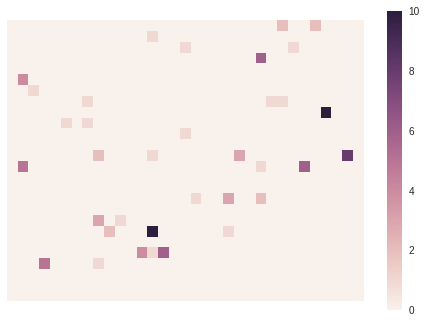

In [52]:
plot_command_vector(adversary_test_inputs[0])

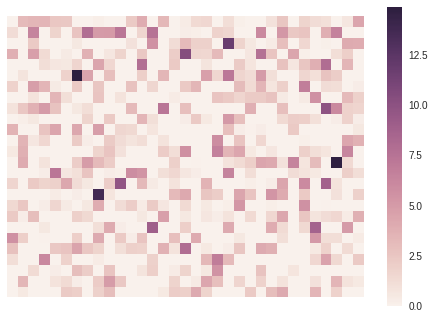

In [53]:
 plot_command_vector(adversarial_examples[0])

In [54]:
 adversarial_examples[0] >= adversary_test_inputs[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Additive-only Momentum Iterative Method

In [0]:
import tensorflow as tf

from cleverhans.attacks import optimize_linear
from cleverhans.compat import reduce_sum, reduce_mean, softmax_cross_entropy_with_logits
from cleverhans import utils_tf


class AdditiveMomentumIterativeMethod(cleverhans.attacks.MomentumIterativeMethod):
  """
  Modifies the The Momentum Iterative Method (Dong et al. 2017) to produce additive
  perturbations only.
  
  If it finds the optimal perturbation to be negative, a random addition is performed instead.
  
  Original paper link: https://arxiv.org/pdf/1710.06081.pdf
  
  :param model: cleverhans.model.Model
  :param sess: optional tf.Session
  :param dtypestr: dtype of the data
  :param kwargs: passed through to super constructor
  """

  def generate(self, x, **kwargs):
    """
    Generate symbolic graph for adversarial examples and return.
    :param x: The model's symbolic inputs.
    :param kwargs: Keyword arguments. See `parse_params` for documentation.
    """
    # Parse and save attack-specific parameters
    assert self.parse_params(**kwargs)

    asserts = []

    # If a data range was specified, check that the input was in that range
    if self.clip_min is not None:
      asserts.append(utils_tf.assert_greater_equal(x,
                                                   tf.cast(self.clip_min,
                                                           x.dtype)))

    if self.clip_max is not None:
      asserts.append(utils_tf.assert_less_equal(x,
                                                tf.cast(self.clip_max,
                                                        x.dtype)))

    # Initialize loop variables
    momentum = tf.zeros_like(x)
    adv_x = x

    # Fix labels to the first model predictions for loss computation
    y, _nb_classes = self.get_or_guess_labels(x, kwargs)
    y = y / reduce_sum(y, 1, keepdims=True)
    targeted = (self.y_target is not None)

    def cond(i, _, __):
      """Iterate until number of iterations completed"""
      return tf.less(i, self.nb_iter)

    def body(i, ax, m):
      """Do a momentum step"""
      logits = self.model.get_logits(ax)
      loss = softmax_cross_entropy_with_logits(labels=y, logits=logits)
      if targeted:
        loss = -loss

      # Define gradient of loss wrt input
      grad, = tf.gradients(loss, ax)

      # Normalize current gradient and add it to the accumulated gradient
      red_ind = list(range(1, len(grad.get_shape())))
      avoid_zero_div = tf.cast(1e-12, grad.dtype)
      grad = grad / tf.maximum(
          avoid_zero_div,
          reduce_mean(tf.abs(grad), red_ind, keepdims=True))
      m = self.decay_factor * m + grad

      optimal_perturbation = optimize_linear(m, self.eps_iter, self.ord)
      optimal_perturbation = tf.maximum(optimal_perturbation, tf.zeros_like(optimal_perturbation))
        
      if self.ord == 1:
        raise NotImplementedError("This attack hasn't been tested for ord=1."
                                  "It's not clear that FGM makes a good inner "
                                  "loop step for iterative optimization since "
                                  "it updates just one coordinate at a time.")

      # Update and clip adversarial example in current iteration
      ax = ax + optimal_perturbation
      ax = x + utils_tf.clip_eta(ax - x, self.ord, self.eps)

      if self.clip_min is not None and self.clip_max is not None:
        ax = utils_tf.clip_by_value(ax, self.clip_min, self.clip_max)

      ax = tf.stop_gradient(ax)

      return i + 1, ax, m

    _, adv_x, _ = tf.while_loop(
        cond, body, (tf.zeros([]), adv_x, momentum), back_prop=True,
        maximum_iterations=self.nb_iter)

    if self.sanity_checks:
      with tf.control_dependencies(asserts):
        adv_x = tf.identity(adv_x)

    return adv_x


In [116]:
ami_attack = AdditiveMomentumIterativeMethod(substitute_ch, sess=tensorflow_session)
ami_params = {
    'eps': 100.0,
    'eps_iter': 1.0,
    'nb_iter': 100,
    'ord': numpy.inf,
    'clip_min': 0.0,
    'clip_max': 100.0,
}

summary, adversarial_examples = run_targeted_attack_against_all_users(adversary_test_inputs[0], adversary_test_labels[0], ami_attack, ami_params)
summary

[INFO 2019-03-17 17:39:45,463 cleverhans] Constructing new graph for attack AdditiveMomentumIterativeMethod


A targeted attack was successful against 19/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,0,1.000000
1,43,1,18,1.000000
2,43,2,2,1.000000
3,43,3,3,1.000000
4,43,4,0,1.000000
5,43,5,5,1.000000
6,43,6,12,1.000000
7,43,7,27,1.000000
8,43,8,8,1.000000
9,43,9,9,1.000000


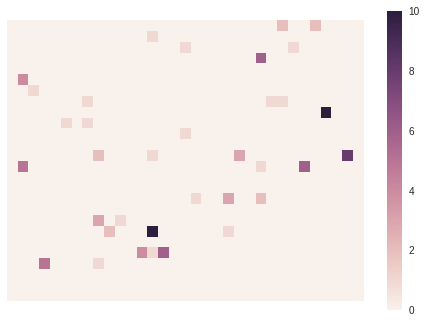

In [111]:
plot_command_vector(adversary_test_inputs[0])

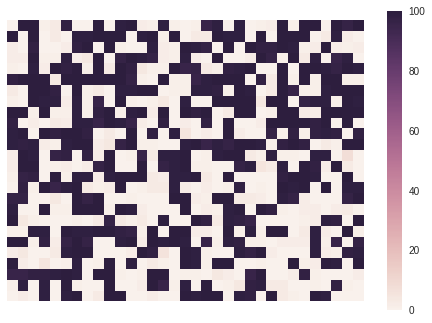

In [118]:
plot_command_vector(adversarial_examples[0])

# An End-to-End Attack

In this section, we use the models and attacks developed above to perform a complete attack on the intrusion detection system.

First we define two functions:
  1. `script_to_command_vector` :: converts a list of bash commands into a command vector (as if it werre generated by `acct`).
  2. `pad_script` :: takes an input script and generats an output script with the same behaviour, but with the command counts specified by command_vector.

In [0]:
def script_to_command_vector(script):
    lines = script.split("\n")  # ['netscape', 'sh ./my-script.sh', ...]
    commands = [
        line.split(" ")[0] for line in lines
    ]  # ['netscape', 'sh', ...]
    
    commands = pandas.Series(commands).astype(command_dtype)
    commands_one_hot = pandas.get_dummies(commands)
    command_counts = commands_one_hot.sum()
    
    return command_counts

In [0]:
# For our proof-of-concept, just append --help to turn our commands into no-ops. This won't
# actually work for all of these commands, but proves the point.
COMMAND_TO_NOOP = {command: command + " --help" for command in commands}

def pad_script(original_script, target_command_counts):
    # First, calculate the command counts of the input script:
    original_command_counts = script_to_command_vector(original_script)
    
    # Find the number of each command we need to pad by:
    additional_command_counts = target_command_counts - original_command_counts
    
    # Loop over additional_command_counts and append no-op commands for each additional
    # command needed:
    
    # TODO: finish this
    padded_script = original_script
    
    return padded_script

In [0]:
def masq(script, target_user):
    command_vector = script_to_command_vector(script)
    original_command_vectors = numpy.array([command_vector])

    target_labels = keras.utils.to_categorical(numpy.array([target_user]), num_classes=50)

    attack = FastGradientMethod(substitute_ch, sess=tensorflow_session)
    adversarial_examples = attack.generate_np(
        original_command_vectors,
        y_target=target_labels,
        eps=1.0,
        ord=numpy.inf,
        clip_min=0.0,
        clip_max=100.0,
    )

    predicted_labels = oracle.predict(adversarial_examples)
    
    adversarial_example = adversarial_examples[0]
    predicted_label = numpy.argmax(predicted_labels[0])
    
    if predicted_label == target_user:
        fool = 'We have fooled the model!'
    else:
        fool = 'We have failed to fool the model... oh dear.'
    
    print('These are the adversarial example that was generated: \n')
    print(str(adversarial_example))
    print('\n and this is the predicted user: \n')
    print(str(predicted_label))
    print('\n '+fool)


masq(
    script="""
        cat
        hostname
        awk
        stty
        tset
        sh
        chmod
        chmod
        chmod
        chmod
        news
        sh ./my-script.sh
        netstat
        netscape
        netscape
        netscape
        netscape
        netscape
        netscape
    """,
    target_user=16,    
    )